In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

# import pyarrow  # noqa
# pyarrow.set_cpu_count(8)  # noqa
import warnings  # noqa
warnings.filterwarnings('ignore')  # noqa

from lmfit.models import *
from scipy.optimize import curve_fit
from scipy import stats
import numpy as np
import pandas as pd
from pyarrow import csv
from lmfit.models import GaussianModel, PolynomialModel, BreitWignerModel, LognormalModel, Model
from multiprocessing import Pool
import sys
from typing import Dict
from matplotlib.pyplot import legend


MASS_P = 0.93827208816
E0 = 4.81726
MASS_E = 0.00051099895


def clock_to_time(clock: float) -> str:
    millis = clock * 1000
    hours = int((millis/(1000*60*60)) % 24)
    seconds = int((millis/1000) % 60)
    minutes = int((millis/(1000*60)) % 60)
    hours = int((millis/(1000*60*60)) % 24)
    if hours > 1:
        return f"{hours}:{minutes}:{seconds}"
    elif minutes > 1:
        return f"{minutes} min {seconds} sec"
    elif seconds > 1:
        return f"{seconds} sec"
    else:
        return f"{millis} ms"


def timeit(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()

        print(f'{method.__name__ }  {clock_to_time(te - ts)}')
        return result
    return timed


def vec(method):
    return np.vectorize(method, cache=True, otypes=["float32"])


@vec
def calc_W(e_p, e_theta, e_phi):
    px = e_p*np.sin(e_theta)*np.cos(e_phi)
    py = e_p*np.sin(e_theta)*np.sin(e_phi)
    pz = e_p*np.cos(e_theta)

    e_beam = np.array([0, 0, np.sqrt(E0**2-MASS_E**2), E0])
    e_prime = np.array([px, py, pz, np.linalg.norm([px, py, pz, MASS_E])])
    p_targ = np.array([0, 0, 0.0, MASS_P])
    temp = e_beam - e_prime + p_targ
    temp2 = temp[0]*temp[0]+temp[1]*temp[1]+temp[2]*temp[2]-temp[3]*temp[3]
    return np.sqrt(-temp2)


@vec
def q2_calc(e_p, e_theta, e_phi):
    px = e_p*np.sin(e_theta)*np.cos(e_phi)
    py = e_p*np.sin(e_theta)*np.sin(e_phi)
    pz = e_p*np.cos(e_theta)

    e_beam = np.array([0, 0, np.sqrt(E0**2-MASS_E**2), E0])
    e_prime = np.array([px, py, pz, np.linalg.norm([px, py, pz, MASS_E])])

    temp = e_beam - e_prime
    temp2 = temp[0]*temp[0]+temp[1]*temp[1]+temp[2]*temp[2]-temp[3]*temp[3]

    return temp2


@vec
def center_phi(phi, sec):
    sector = {
        1: 90,
        2: 30,
        3: -30,
        4: -90,
        5: -150,
        6: 150
    }

    return phi-sector[sec]


@vec
def Theta_e_calc(theta_p):
    return 2 * np.arctan(MASS_P/((E0+MASS_P)*np.tan(theta_p)))


@vec
def momentum_e_calc(theta_e):
    return E0 / (1 + (2*E0*np.sin(theta_e/2)**2)/MASS_P)


def G(e_phi, theta_e,
      alpha_A, beta_A, gamma_A,
      alpha_B, beta_B, gamma_B,
      alpha_C, beta_C, gamma_C,
      alpha_D, beta_D, gamma_D,
      alpha_E, beta_E, gamma_E):
    """
    Equations 5.20 - 5.22 in KPark thesis (p. 71)
    """
    A = (alpha_A * theta_e**2 + beta_A * theta_e + gamma_A) * e_phi**4
    B = (alpha_B * theta_e**2 + beta_B * theta_e + gamma_B) * e_phi**3
    C = (alpha_C * theta_e**2 + beta_C * theta_e + gamma_C) * e_phi**2
    D = (alpha_D * theta_e**2 + beta_D * theta_e + gamma_D) * e_phi
    E = (alpha_E * theta_e**2 + beta_E * theta_e + gamma_E)

    return A + B + C + D + E


@vec
def correction(e_phi, theta_e, parms):
    """
    Equations 5.20 - 5.22 in KPark thesis (p. 71)
    """
    A = (parms['alpha_A'] * theta_e**2 + parms['beta_A']
         * theta_e + parms['gamma_A']) * e_phi**4
    B = (parms['alpha_B'] * theta_e**2 + parms['beta_B']
         * theta_e + parms['gamma_B']) * e_phi**3
    C = (parms['alpha_C'] * theta_e**2 + parms['beta_C']
         * theta_e + parms['gamma_C']) * e_phi**2
    D = (parms['alpha_D'] * theta_e**2 + parms['beta_D']
         * theta_e + parms['gamma_D']) * e_phi
    E = (parms['alpha_E'] * theta_e**2 +
         parms['beta_E'] * theta_e + parms['gamma_E'])

    return A + B + C + D + E


def Dtheta(X, A, B, C, D):
    """
    Mom Corrections for e6 (CLAS-NOTE 2003-005)
    """
    e_phi, theta_e = X
    # e_phi = np.rad2deg(e_phi)
    first = (A+B*e_phi)*(np.cos(theta_e)/np.cos(e_phi))
    second = (C+D*e_phi)*np.sin(theta_e)
    return first + second


def Dpp(X, p, Bt, E, F, G, H):
    e_phi, theta_e = X
    Bt = 1
    first = (E+F*e_phi)*(np.cos(theta_e)/np.cos(e_phi))
    second = (G+H*e_phi)*np.sin(theta_e)
    return (first + second)*(p/Bt)


@timeit
def read_file(file_name: str) -> pd.DataFrame:
    dtype = {
        "e_p": "float32",
        "e_theta": "float32",
        "e_phi": "float32",
        "p_p": "float32",
        "p_theta": "float32",
        "p_phi": "float32",
        "W_uncorr": "float32",
        "Q2_uncorr": "float32",
        "sector": "int8",
        "e_phi_center": "float32",
        "e_theta_calc": "float32",
        "delta_theta":   "float32",
        "p_p_calc":      "float32"
    }

    pyTable = csv.read_csv(
        file_name,
        read_options=csv.ReadOptions(use_threads=True),
        convert_options=csv.ConvertOptions(column_types=dtype)
    )
    df = pyTable.to_pandas(strings_to_categorical=True)

    df = df[(df.W_uncorr > 0.5) & (df.W_uncorr < 1.5)]
    df['e_theta'] = np.deg2rad(df.e_theta)
    df['e_phi_center'] = center_phi(df.e_phi, df.sector)
    df['e_phi'] = np.deg2rad(df.e_phi, dtype=np.float32)
    df['p_theta'] = np.deg2rad(df.p_theta, dtype=np.float32)
    df['p_phi'] = np.deg2rad(df.p_phi, dtype=np.float32)
    df['e_theta_calc'] = Theta_e_calc(df.p_theta)
    df['delta_theta'] = df['e_theta_calc'] - df['e_theta']
    df['e_p_calc'] = momentum_e_calc(df['e_theta'])
    df['delta_p'] = (df['e_p'] - df['e_p_calc'])/df['e_p']
    df['p_p_calc'] = Theta_e_calc(df.e_theta_calc)
    df.dropna(inplace=True)

    dtype_pd = {
        "e_p": "float16",
        "e_theta": "float16",
        "e_phi": "float16",
        "p_p": "float16",
        "p_theta": "float16",
        "p_phi": "float16",
        "W_uncorr": "float16",
        "Q2_uncorr": "float16",
        "sector": "int8",
        "e_phi_center": "float16",
        "e_theta_calc": "float16",
        "delta_theta":   "float16",
        "p_p_calc":      "float16"
    }
    df = df.astype(dtype_pd)

    return df


def get_min_max(x, past=0.1):
    a, b = np.min(x), np.max(x)
    if a <= 0:
        a, b = b, a

    return ((1-past)*a, (1+past)*b)


def dtheta_vs_phi(sector_data: pd.DataFrame, directory: str = ".") -> Dict:
    outputs = dict()
    sec = int(np.mean(sector_data.sector))

    phi_step = 0.5
    phi_steps = np.arange(-30, 30, phi_step)
    theta_step = 1
    theta_steps = np.arange(13, 27, theta_step)

    for theta in theta_steps:
        phi_theta = []
        fig, ax = plt.subplots(figsize=(12, 9))
        dt_theta = sector_data[(np.rad2deg(sector_data.e_theta) > theta) & (
            (np.rad2deg(sector_data.e_theta)) <= theta+theta_step)]
        ax.hist2d(dt_theta.e_phi_center.to_numpy(),
                  dt_theta.delta_theta.to_numpy(), bins=250, range=[[-30, 30], [-0.01, 0.01]])

        for phi in phi_steps:
            dt = dt_theta[(dt_theta.e_phi_center > phi) & (
                dt_theta.e_phi_center <= phi+phi_step)]

            if len(dt) < 20:
                continue

            phi = np.mean(dt.e_phi_center.to_numpy())
            delta_t = np.mean(dt.delta_theta.to_numpy())

            try:
                # fig2, ax2 = plt.subplots(figsize=(12, 9))
                yy, xx = np.histogram(dt.delta_theta.to_numpy(),
                                      bins=1000, range=(-0.05, 0.05))
                # yy, xx, _ = ax2.hist(dt.delta_theta.to_numpy(), bins=1000, range=(-0.05, 0.05))
                xx = (xx[1:]+xx[:-1])/2.0
                g_mod = BreitWignerModel()
                g_pars = g_mod.guess(yy, x=xx)
                g_out = g_mod.fit(yy, g_pars, x=xx)
                # np.mean(dt.delta_theta.to_numpy())-g_out.best_values['center']
                # xxs = np.linspace(-0.05, 0.05, 2000)
                # ax2.plot(xxs, g_mod.eval(params=g_out.params, x=xxs))
                delta_t = g_out.best_values['center']
                yerr = g_out.best_values['sigma']

                if yerr > 0.01:
                    yerr = 0
                # fig2.savefig(f"plots/slices/slice_{theta}_{phi}_{sec}.png")
                ax.errorbar(phi, delta_t,
                            yerr=yerr, fmt='.', c='red')
                # del fig2
                # del ax2
            except ValueError:
                pass

            phi_theta.append([phi, delta_t])

        if len(phi_theta) > 3:
            x = np.transpose(phi_theta)[0]
            y = np.transpose(phi_theta)[1]

            z = np.polyfit(x, y, 4)
            func = np.poly1d(z)
            xs = np.linspace(-30, 30, 2000)
            ax.plot(xs, func(xs), label=f'{z}')
            ax.legend()
            outputs[f'theta_{theta}'] = tuple(z)

        # popt, pcov = curve_fit(Dtheta, x, y, maxfev=3400)
        # ax.plot(xs, Dtheta(xs, *popt), label=f'{popt}')

        ax.set_ylim(-0.01, 0.01)
        ax.set_xlabel(f"$\phi$")
        ax.set_ylabel(f"$\Delta \\theta$")
        #fig.savefig(f'{directory}/fit_sec_{sec}_theta_{theta}.png')
        plt.show()

        del fig, ax

    return outputs


def dtheta_vs_phi_corrected(sector_data: pd.DataFrame, directory: str = "."):
    sec = int(np.mean(sector_data.sector))

    phi_step = 0.5
    phi_steps = np.arange(-30, 30, phi_step)
    theta_step = 1
    theta_steps = np.arange(13, 27, theta_step)

    for theta in theta_steps:
        phi_theta = []
        phi_theta_corr = []
        fig, ax = plt.subplots(figsize=(12, 9))
        dt_theta = sector_data[(np.rad2deg(sector_data.e_theta) > theta) & (
            (np.rad2deg(sector_data.e_theta)) <= theta+theta_step)]

        for phi in phi_steps:
            dt = dt_theta[(dt_theta.e_phi_center > phi) & (
                dt_theta.e_phi_center <= phi+phi_step)]

            if len(dt) < 20:
                continue

            phi = np.mean(dt.e_phi_center.to_numpy())
            delta_t = np.mean(dt.delta_theta.to_numpy())
            delta_t_corr = np.mean(dt.delta_theta_corr.to_numpy())

            try:
                yy, xx = np.histogram(dt.delta_theta.to_numpy(),
                                      bins=1000, range=(-0.05, 0.05))
                xx = (xx[1:]+xx[:-1])/2.0
                g_mod = BreitWignerModel()
                g_pars = g_mod.guess(yy, x=xx)
                g_out = g_mod.fit(yy, g_pars, x=xx)
                delta_t = g_out.best_values['center']
                ax.errorbar(phi, delta_t, fmt='+', c='red')

                yy, xx = np.histogram(dt.delta_theta_corr.to_numpy(),
                                      bins=1000, range=(-0.05, 0.05))
                xx = (xx[1:]+xx[:-1])/2.0
                g_mod = BreitWignerModel()
                g_pars = g_mod.guess(yy, x=xx)
                g_out = g_mod.fit(yy, g_pars, x=xx)
                delta_t_corr = g_out.best_values['center']
                ax.errorbar(phi, delta_t_corr, fmt='.', c='blue', alpha=0.3)

            except ValueError:
                pass

            phi_theta.append([phi, delta_t])
            phi_theta_corr.append([phi, delta_t_corr])

        if len(phi_theta) > 3:
            x = np.transpose(phi_theta)[0]
            y = np.transpose(phi_theta)[1]
            y_corr = np.transpose(phi_theta_corr)[1]

            z = np.polyfit(x, y, 4)
            func = np.poly1d(z)
            xs = np.linspace(-30, 30, 2000)
            ax.plot(xs, func(xs), label=f'{z}')

            z = np.polyfit(x, y_corr, 4)
            func = np.poly1d(z)
            xs = np.linspace(-30, 30, 2000)
            ax.plot(xs, func(xs), label=f'{z}')

            ax.legend()

        #ax.set_ylim(-0.01, 0.01)
        ax.set_xlabel(f"$\phi$")
        ax.set_ylabel(f"$\Delta \\theta$")
        #fig.savefig(f'{directory}/after_fit_sec_{sec}_theta_{theta}.png')
        plt.show()

        del fig, ax


def deltap_vs_phi(sector_data: pd.DataFrame, directory: str = ".") -> Dict:
    outputs = dict()
    sec = int(np.mean(sector_data.sector))

    phi_step = 0.5
    phi_steps = np.arange(-30, 30, phi_step)
    theta_step = 1
    theta_steps = np.arange(13, 27, theta_step)

    for theta in theta_steps:
        phi_theta = []
        fig, ax = plt.subplots(figsize=(12, 9))
        dt_theta = sector_data[(np.rad2deg(sector_data.e_theta) > theta) & (
            (np.rad2deg(sector_data.e_theta)) <= theta+theta_step)]
        ax.hist2d(dt_theta.e_phi_center.to_numpy(),
                  dt_theta.delta_p.to_numpy(), bins=250,
                  range=[[-30, 30], [-0.2, 0.2]]
                  )

        for phi in phi_steps:
            dt = dt_theta[(dt_theta.e_phi_center > phi) & (
                dt_theta.e_phi_center <= phi+phi_step)]

            if len(dt) < 20:
                continue

            phi = np.mean(dt.e_phi_center.to_numpy())
            delta_t = np.mean(dt.delta_p.to_numpy())

            try:
                # fig2, ax2 = plt.subplots(figsize=(12, 9))
                yy, xx = np.histogram(dt.delta_p.to_numpy(),
                                      bins=1000, range=(-0.05, 0.05))
                # yy, xx, _ = ax2.hist(dt.delta_theta.to_numpy(), bins=1000, range=(-0.05, 0.05))
                xx = (xx[1:]+xx[:-1])/2.0
                g_mod = BreitWignerModel()
                g_pars = g_mod.guess(yy, x=xx)
                g_out = g_mod.fit(yy, g_pars, x=xx)
                # np.mean(dt.delta_theta.to_numpy())-g_out.best_values['center']
                # xxs = np.linspace(-0.05, 0.05, 2000)
                # ax2.plot(xxs, g_mod.eval(params=g_out.params, x=xxs))
                delta_t = g_out.best_values['center']
                yerr = g_out.best_values['sigma']

                # fig2.savefig(f"plots/slices/slice_{theta}_{phi}_{sec}.png")
                ax.errorbar(phi, delta_t,
                            yerr=yerr, fmt='.', c='red')
                # del fig2
                # del ax2
            except ValueError:
                pass

            phi_theta.append([phi, delta_t])

        if len(phi_theta) > 3:
            x = np.transpose(phi_theta)[0]
            y = np.transpose(phi_theta)[1]

            z = np.polyfit(x, y, 4)
            func = np.poly1d(z)
            xs = np.linspace(-30, 30, 2000)
            ax.plot(xs, func(xs), label=f'{z}')
            ax.legend()
            outputs[f'theta_{theta}'] = tuple(z)

        # popt, pcov = curve_fit(Dtheta, x, y, maxfev=3400)
        # ax.plot(xs, Dtheta(xs, *popt), label=f'{popt}')

        ax.set_ylim(-0.2, 0.2)
        ax.set_xlabel(f"$\phi$")
        ax.set_ylabel(f"$\Delta P$")
        fig.savefig(f'{directory}/fit_momentum_sec_{sec}_theta_{theta}.png')

        del fig, ax

    return outputs


def second_fit(sector, fit_ABCDE, directory):
    theta_step = 1
    theta_steps = np.arange(13, 27, theta_step)
    outputs = dict()

    fig, ax = plt.subplots(figsize=(12, 9))
    xs = np.linspace(10, 30, 1000)

    markers = "os^v>"
    for i, letter in enumerate("ABCDE"):
        data = []
        thetas = []
        for theta in theta_steps:
            if f'theta_{theta}' in fit_ABCDE:
                thetas.append(theta)
                data.append(fit_ABCDE[f'theta_{theta}'][i] * 10**(5-i))

        ax.scatter(thetas, data, label=letter, alpha=0.5, marker=markers[i])
        z = np.polyfit(thetas, data, 2)
        func = np.poly1d(z)
        ax.plot(xs, func(xs), label=f'{z}')

        for j, greek in enumerate(['alpha', 'beta', 'gamma']):
            outputs[f'{greek}_{letter}'] = z[j]
    ax.legend()
    fig.savefig(f"{directory}/fit_{sector}.png")

    return outputs






In [2]:
df = read_file("/Users/tylern/Data/e1d/mom_corr_elastic.dat")
sector_data = [df[df.sector == sec] for sec in range(1, 7)]
del df

sec = sector_data[0]
sec.head()

read_file  2 sec


,e_p,e_theta,e_phi,p_p,p_theta,p_phi,W_uncorr,Q2_uncorr,sector,e_phi_center,e_theta_calc,delta_theta,e_p_calc,delta_p,p_p_calc
18,3.658203,0.349365,1.657227,1.820312,0.746582,-1.485352,0.961426,2.128906,1,4.925781,0.348877,-0.000535,3.677019,-0.004890,0.842773
34,4.117188,0.244629,1.529297,1.252930,0.927246,-1.598633,1.006836,1.181641,1,-2.371094,0.243286,-0.001378,4.178357,-0.014891,1.162109
39,3.701172,0.347656,1.434570,1.844727,0.749512,-1.699219,0.919434,2.130859,1,-7.796875,0.346680,-0.000793,3.685873,0.003873,0.847656
40,4.132812,0.249023,1.502930,1.302734,0.917480,-1.621094,0.966797,1.228516,1,-3.884766,0.248291,-0.000729,4.158485,-0.006027,1.142578
42,3.498047,0.310791,1.812500,1.604492,0.809082,-1.317383,1.320312,1.614258,1,13.851562,0.308594,-0.002302,3.866334,-0.105502,0.945801


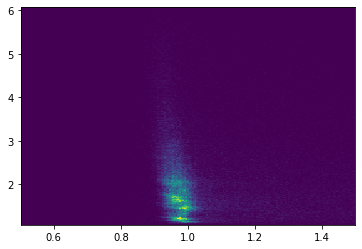

In [3]:
plt.hist2d(sec.W_uncorr, sec.Q2_uncorr, bins=200)
plt.show()

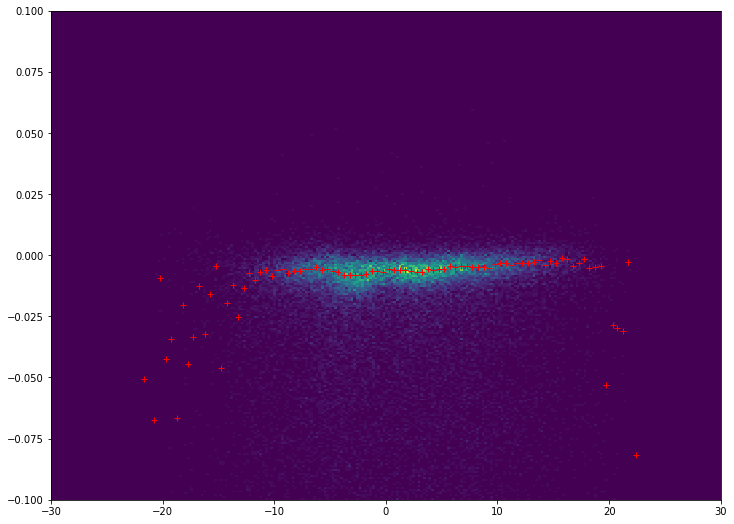

In [9]:
def dtheta_vs_phi_E6(sec):
    phi_theta = []
    fig, ax = plt.subplots(figsize=(12, 9))
    ax.hist2d(sec.e_phi_center.to_numpy(),
                  sec.delta_theta.to_numpy(), bins=250, range=[[-30, 30], [-0.01, 0.01]])
    
    phi_step = 0.5
    phi_steps = np.arange(-30, 30, phi_step)
    for phi in phi_steps:
        dt = sec[(sec.e_phi_center > phi) & (sec.e_phi_center <= phi+phi_step)]
        if dt.size < 10:
            continue
        phi = np.mean(dt.e_phi_center.to_numpy())
        delta_t = np.mean(dt.delta_theta.to_numpy())

        yy, xx = np.histogram(dt.delta_theta.to_numpy(),
                              bins=1000, range=(-0.05, 0.05))
        xx = (xx[1:]+xx[:-1])/2.0
        g_mod = BreitWignerModel()
        g_pars = g_mod.guess(yy, x=xx)
        g_out = g_mod.fit(yy, g_pars, x=xx)
        delta_t = g_out.best_values['center']
        ax.errorbar(phi, delta_t, fmt='+', c='red')
        
        delta_t = g_out.best_values['center']
        yerr = g_out.best_values['sigma']
        
        phi_theta.append([phi, delta_t])


    
    plt.show()
    
    
def dmom_vs_phi_E6(sec):
    phi_theta = []
    fig, ax = plt.subplots(figsize=(12, 9))
    ax.hist2d(sec.e_phi_center.to_numpy(),
                  sec.delta_p.to_numpy(), bins=250, range=[[-30, 30], [-0.1, 0.1]])
    
    phi_step = 0.5
    phi_steps = np.arange(-30, 30, phi_step)
    for phi in phi_steps:
        dt = sec[(sec.e_phi_center > phi) & (sec.e_phi_center <= phi+phi_step)]
        if dt.size < 10:
            continue
        phi = np.mean(dt.e_phi_center.to_numpy())
        delta_p = np.mean(dt.delta_p.to_numpy())

        yy, xx = np.histogram(dt.delta_p.to_numpy(),
                              bins=1000, 
                              range=(-0.1, 0.1)
                             )
        xx = (xx[1:]+xx[:-1])/2.0
        g_mod = BreitWignerModel()
        g_pars = g_mod.guess(yy, x=xx)
        g_out = g_mod.fit(yy, g_pars, x=xx)
        delta_t = g_out.best_values['center']
        ax.errorbar(phi, delta_t, fmt='+', c='red')
        
        delta_p = g_out.best_values['center']
        yerr = g_out.best_values['sigma']
        
        phi_theta.append([phi, delta_t])


    
    plt.show()

    
    



dmom_vs_phi_E6(sec)

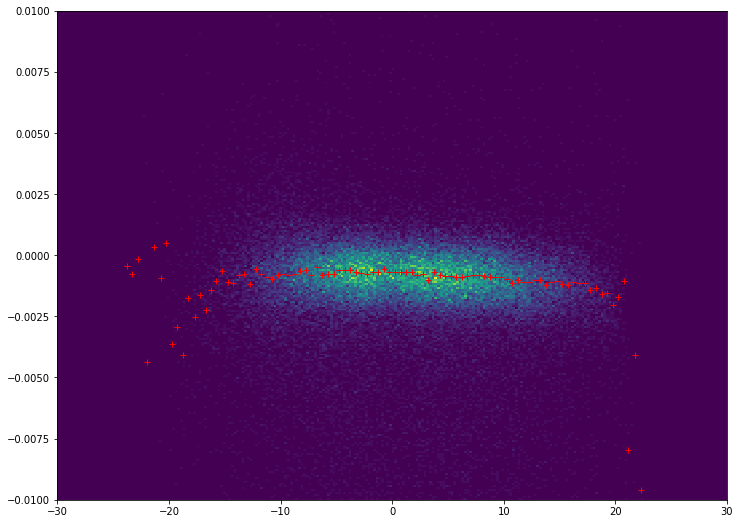

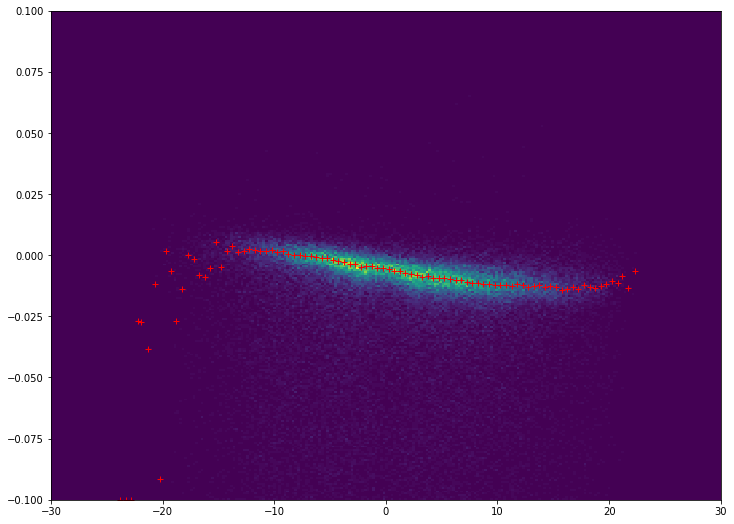

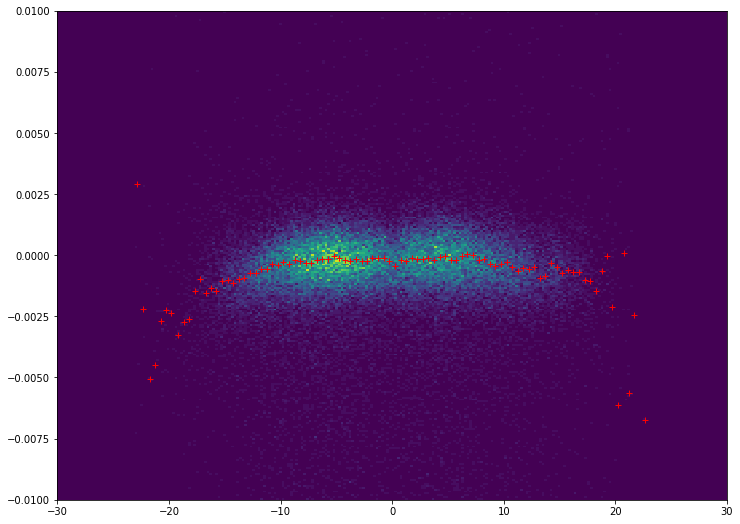

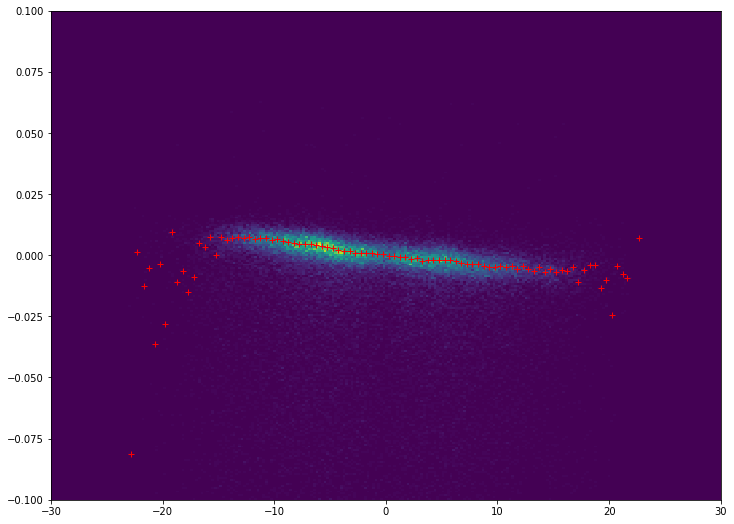

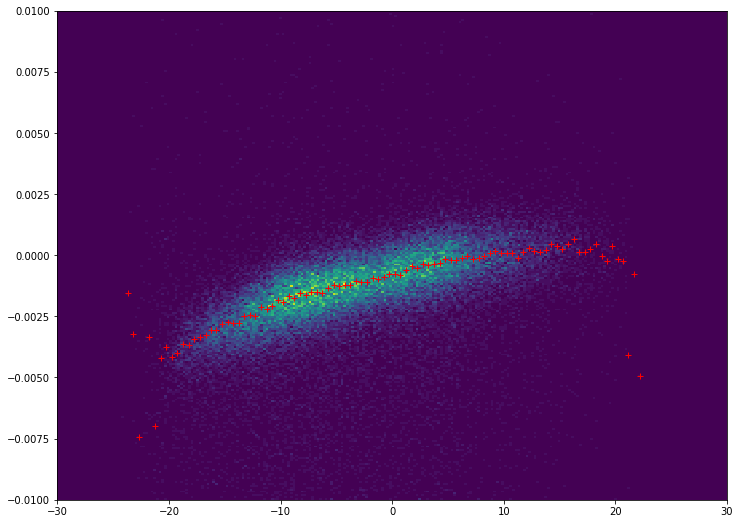

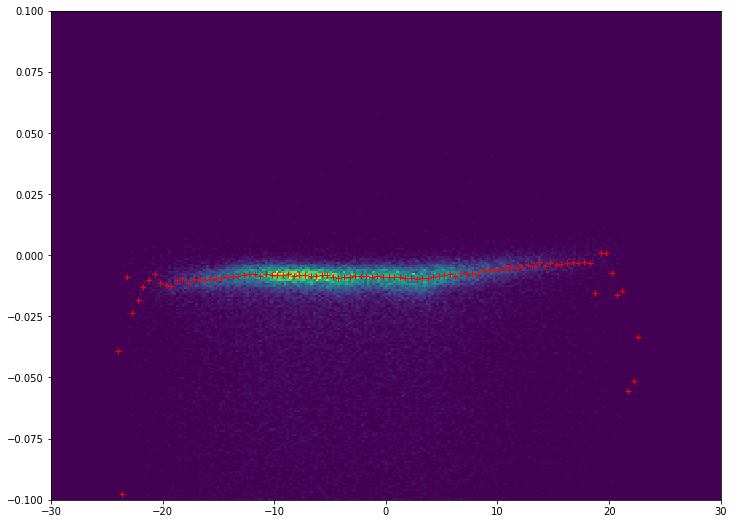

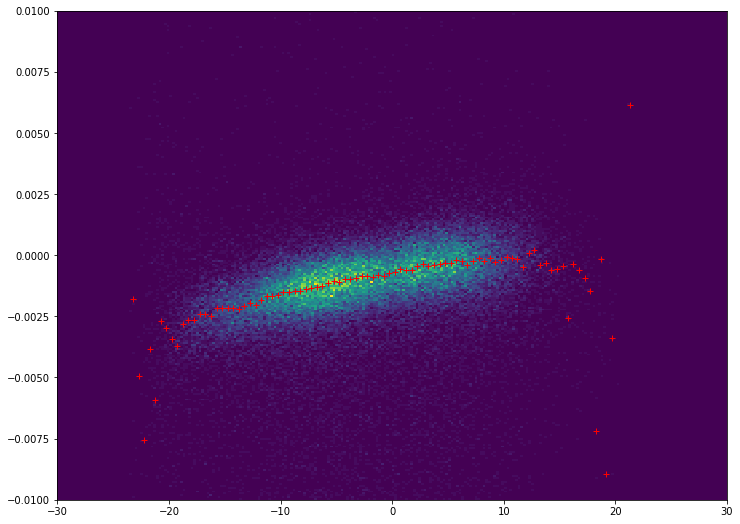

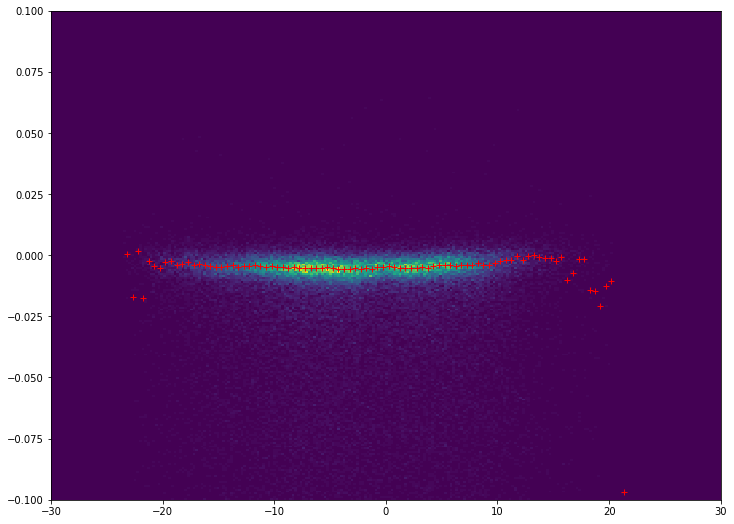

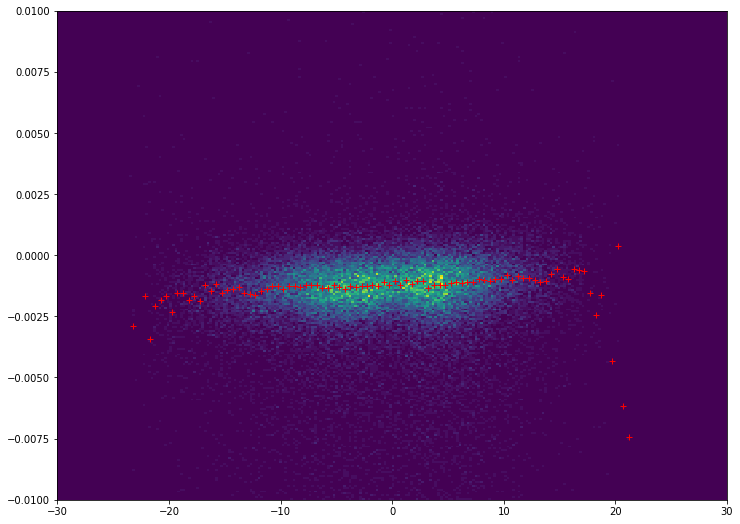

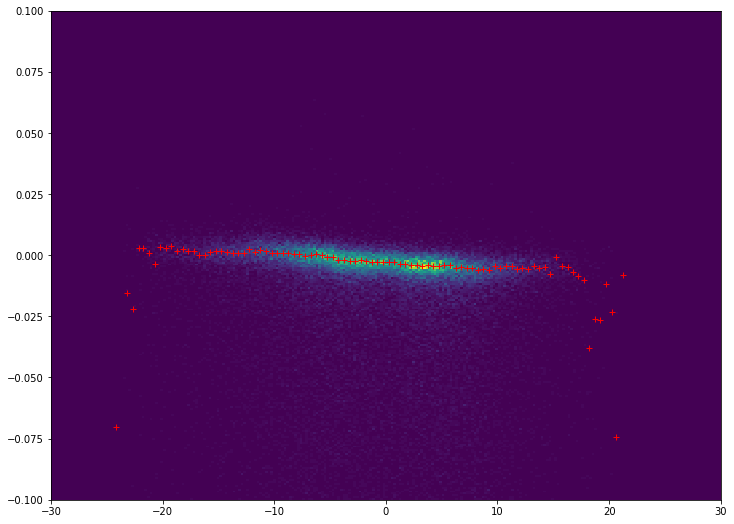

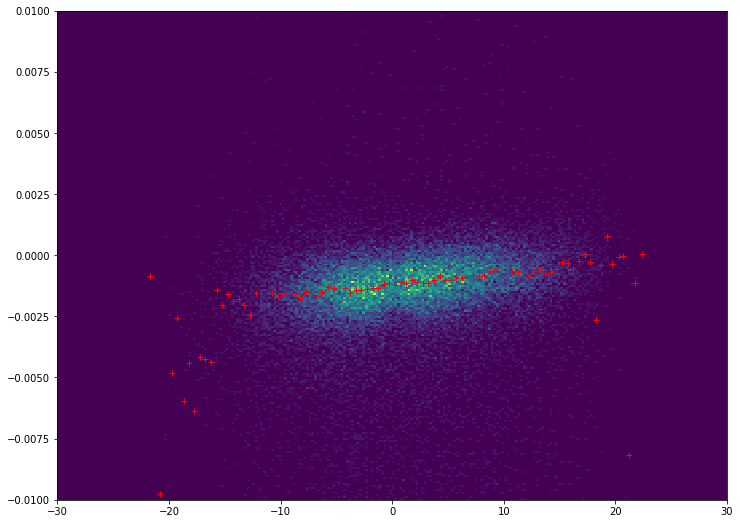

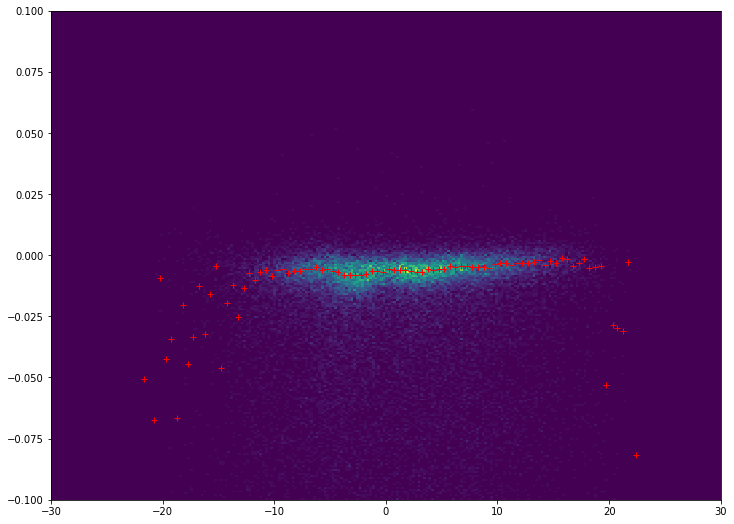

In [10]:
for sec in sector_data:
    dtheta_vs_phi_E6(sec)
    dmom_vs_phi_E6(sec)